Univariate Time Series Forecasting using a LSTM neural network model 

In [21]:
# Import Libraries

import numpy as np
import pandas as pd
from datetime import datetime 
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from datetime import datetime
from datetime import timedelta
sns.set(style="ticks", rc={"lines.linewidth": 1.5})

In [14]:
## use pyspark to import a dataset if necessary

import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.sql.window import Window
from pyspark.context import SparkContext
#date_exp = sqlContext.sql("select * FROM ...")



In [15]:
'''date formatting
date_exp[['payment_date']] = date_exp[['payment_date']].applymap(str).applymap(lambda s: "{}-{}-{}".format(s[4:6],s[6:], s[0:4]))

date_exp['payment_date'] = pd.to_datetime(date_exp.payment_date)
date_exp.set_index('payment_date', inplace=True,drop=True)

date_exp = date_exp[(date_exp['faster_payments']>1)]

check dataset visually

plt.figure(figsize = (20,8))
date_bk.groupby(['payment_date'])[['faster_payments']].mean().plot(lw=2.5, figsize=(12, 5));
plt.show();

'''


'date formatting\ndate_exp[[\'payment_date\']] = date_exp[[\'payment_date\']].applymap(str).applymap(lambda s: "{}-{}-{}".format(s[4:6],s[6:], s[0:4]))\n\ndate_exp[\'payment_date\'] = pd.to_datetime(date_exp.payment_date)\ndate_exp.set_index(\'payment_date\', inplace=True,drop=True)\n\ndate_exp = date_exp[(date_exp[\'faster_payments\']>1)]\n\ncheck dataset visually\n\nplt.figure(figsize = (20,8))\ndate_bk.groupby([\'payment_date\'])[[\'faster_payments\']].mean().plot(lw=2.5, figsize=(12, 5));\nplt.show();\n\n'

In [30]:
life = pd.read_csv('/Users/paul.carroll/Github/Forecasting/data/USlifeexpenctancyBirth.csv',index_col = 'TIME')
life = life.iloc[0:,5:6]
rename_map = {'Value':'Expectancy'}
life.rename(columns=rename_map, inplace=True)
life.tail()

,Expectancy
TIME,
2016,76.2
2017,76.1
2018,76.2
2019,76.3
2020,74.2


<Figure size 1440x576 with 0 Axes>

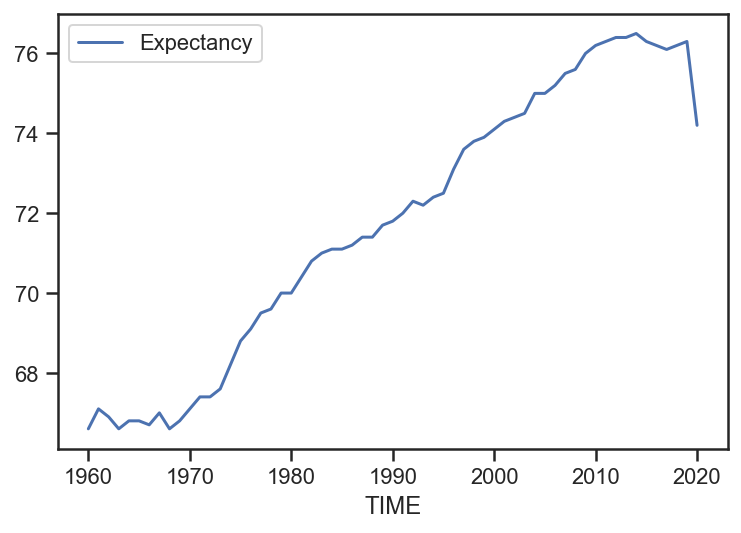

In [17]:
#check your data
plt.figure(figsize = (20,8))
life.plot();

In [18]:

import tensorflow  as tf

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed



RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

ImportError: initialization failed

In [6]:
def split_data(data, test_split):
        l = len(data)
        t_idx = round(l*(1-test_split))
        train, test = data[ : t_idx], data[t_idx : ]
        print(f'train: {len(train)} , test: {len(test)}')
        return train, test

In [9]:
#sequence splitter function

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
# model and variables to run the model 
lstm_seq = np.array(life.Expectancy)
# define number of training steps
n = 2
m = len(lstm_seq)
n_steps_in = m-n
#note that this number is also where x_input length gets defined

# number of forecast steps
n_steps_out = n

# univariate series being used here as dataset for the prediction
n_features = 1


tf.keras.backend.clear_session()

X, y = split_sequence(lstm_seq, n_steps_in, n_steps_out)
X = X.reshape((X.shape[0], X.shape[1], n_features))


model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
#model.add(RepeatVector(n_steps_out))
#model.add(LSTM(100, activation='relu', return_sequences=True))
#model.add(TimeDistributed(Dense(1)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

#fit the model, define number of epochs
model.fit(X, y, epochs=100, verbose=0)

# here used len(lstm_seq) -3, to compare the last 3 of lstm_seq against the predictions
x_input = array(lstm_seq[0:m-n])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)



NameError: name 'tf' is not defined

In [233]:
# model function 
# variable setting
m = len(lstm_seq)
n = 1
n_steps_in = m-n
n_steps_out = n
n_features = 1

def lstm_data(x):

    lstm_seq = np.array(x)
    #n_steps_in, n_steps_out = m-n, n
    X, y = split_sequence(lstm_seq, n_steps_in, n_steps_out)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    #return X,y

#def fit_lstm(data):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=1000, verbose=0)

    x_input = array(lstm_seq[0:m-n])
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    #yhat = int(yhat)
    return(yhat)
              

In [236]:
lstm_data(life.Expectancy)

array([[[80.31193 , 69.487885],
        [80.31828 , 69.4933  ]]], dtype=float32)

In [223]:
# function to run the model repeatedly, and to average the results. 

def run(data, runs):
    #repeats is how many times you want the model to run
    #n is equal to the last value in the dataset that will be in the model, ie n+1 is the number to predict.
    #model will use 0-n.
    #m= n-2
    #n_steps_in, n_steps_out = m-n, 1
    #n_features = 1
    #m this sets the lower boundary for the data selection into the model. Must be at least 1 less than n.
    #datax= prepare_data(data)
    results = list()
    for r in range(runs):
        result = lstm_data(data)
        #print('>#%d: %.3f' % (r+1, result))
        results.append(result)
        msg = np.mean(results)
    return(msg)
 #   summarize_results(results)
    #return(np.mean(results))



In [1]:
run(life.Expectancy,3)

Exception: File `'(life.Expectancy,3).py'` not found.

In [23]:
# mean comparison
import statistics
statistics.mean(life.Expectancy)

71.75409836065573

In [45]:
# function for sliding window mean
def most_recent_mean(df, x):
    a = len(df)
    b = a-x
    y = sum(df.iloc[b:a])
    return y/x

In [46]:
most_recent_mean(life.Expectancy, 5)

75.8